In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'CAD/JPY Exchange Rates'}, xlabel='Date'>

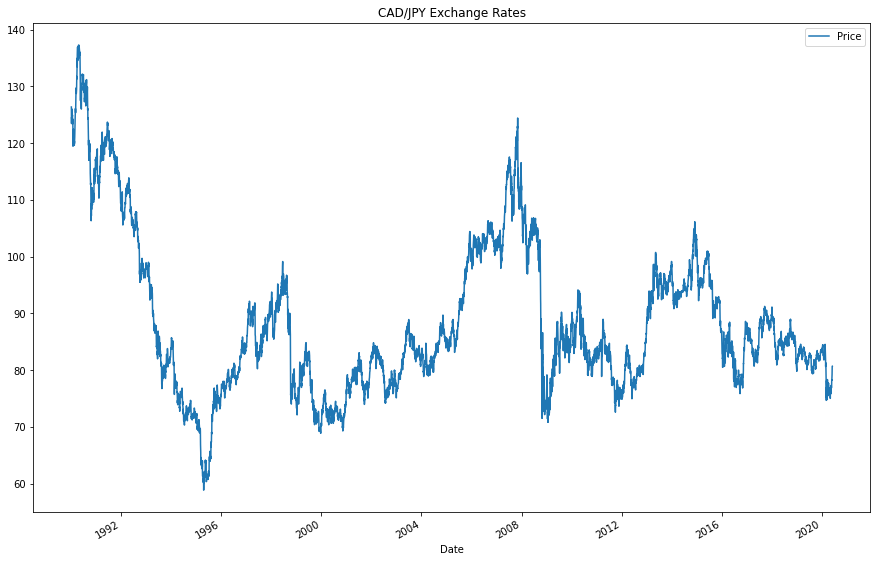

In [4]:
# Plot just the "Price" column from the dataframe:
# YOUR CODE HERE!
cad_jpy_df['Price'].plot(figsize = (15,10), title = "CAD/JPY Exchange Rates", legend = True)

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** YOUR ANSWER HERE

---Long term the CAD/JPY Currency pair appears to be in a downward trend, with the initial price in 1992 being significantly higher than its current price as of 2020. Similarly, you can see an evident crash in 2008, likely from the fallout of the Global Financial Crisis, the currency pair has not returned to this pre GFC high. 

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
# YOUR CODE HERE!
exchange_rate_noise, exchange_rate_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])


In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!

df = pd.DataFrame()
df['Price'] = cad_jpy_df['Price']
df['Noise'] = exchange_rate_noise
df['Trend'] = exchange_rate_trend

df.head()

,Price,Noise,Trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:xlabel='Date'>

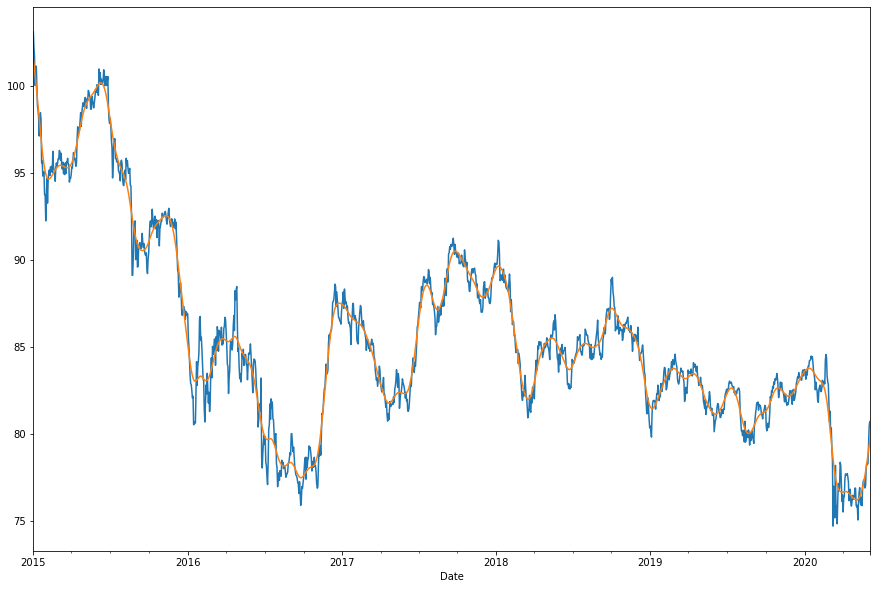

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
df.Price['2015':].plot(figsize = (15,10))
df.Trend['2015':].plot()

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** YOUR ANSWER HERE

It is apparent that a strong pattern persists with the exchange rate price and the trend generated by the Hodrick Prescott Filter. The two price actions move almost in sync with each other, the trend line looks as if it could be a Exponential Weighted Moving Average line, drawing through the middle of the trend with the close prices reverting to this line after any sharp increase or decrease. 

<AxesSubplot:title={'center':'Setle Noise from CAD/JPY Currency Pair'}, xlabel='Date'>

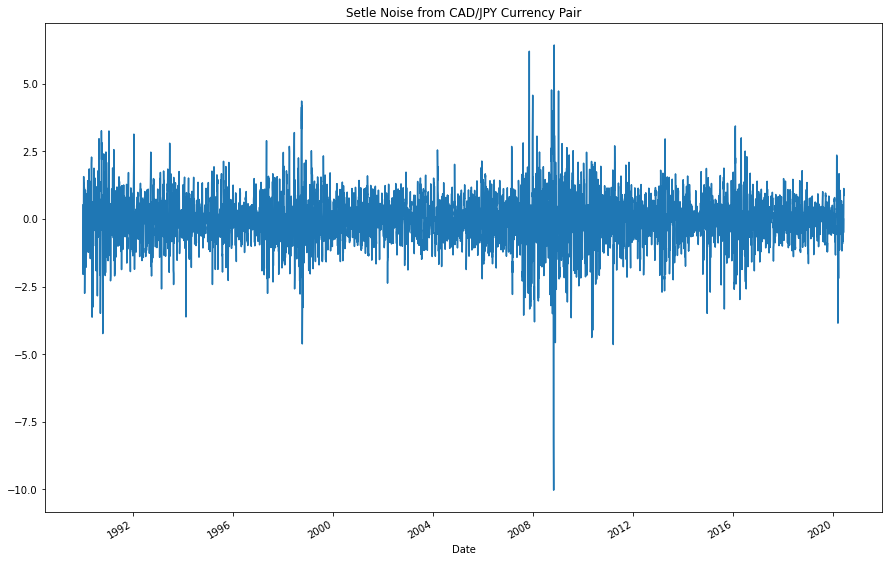

In [8]:

# Plot the Settle Noise
# YOUR CODE HERE!
df.Noise.plot(figsize = (15,10), title = "Setle Noise from CAD/JPY Currency Pair")

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
results = model.fit()

In [11]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Wed, 20 Jan 2021   AIC                          19513.955
Time:                        19:25:33   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1697           +0.0000j           42.1697            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'CAD/JPY Forecast'}>

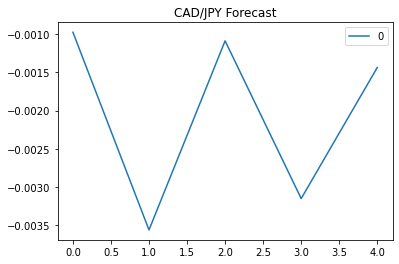

In [12]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="CAD/JPY Forecast")


**Question:** Based on the p-value, is the model a good fit?

**Answer:** Based off of the p-value this model is a good fit at any confidence interval level. 

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
P = 5
D = 1
Q = 1

model = ARIMA(cad_jpy_df['Price'], order=(P, D, Q))

# Fit the model
# YOUR CODE HERE!
results = model.fit()

/Users/Liam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Liam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [14]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Wed, 20 Jan 2021   AIC                          17507.244
Time:                        19:25:37   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'CAD/JPY ARIMA Forecast'}>

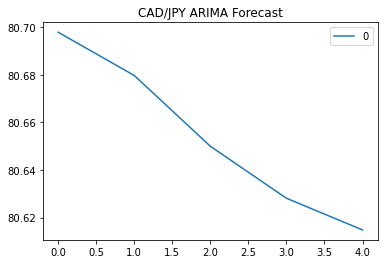

In [15]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!

pd.DataFrame(results.forecast(steps=5)[0]).plot(title="CAD/JPY ARIMA Forecast")




**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

* This model predicts that the japanese yen wil lgo down in value by 0.08 units in the short term.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [6]:
import arch as arch
from arch import arch_model



ModuleNotFoundError: No module named 'arch'

In [5]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
# YOUR CODE HERE!
results_GARCH = model.fit()

NameError: name 'arch_model' is not defined

In [ ]:
# Summarize the model results
# YOUR CODE HERE!
results_GARCH.summary()

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [4]:
# Find the last day of the dataset
last_day = results_GARCH.index.max().strftime('%Y-%m-%d')
last_day

NameError: name 'results_GARCH' is not defined

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = results_GARCH.forecast(start=last_day, horizon=forecast_horizon)
forecasts



In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** This model predicts that volatility will increase in the short term, most likely fallout from the COVID-19 Pandemic and currency volatility. 

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

* With all of the above data I would not purchase the japanese yen at this time. The ARIMA and ARMA forecasts are predicting a downward movement of the yen in the near future and the close price of the Yen has been moving through a downward channel for the past 5 years. 

2. Is the risk of the yen expected to increase or decrease?
    * The risk of the yen is set to increase. The GARCH model is an approach to estimating the volatility of financial markets. Results from the subsequent GARCH analysis predict that volatility will likely increase in the short term. 

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * I would not feel confident trading using these models. Firstly, two models being used to execute a trade without prior due diligence seems a risky way of managing cash. Secondly, the accuracy of these models has not been properly assessed  and backtested. 